# CCF Algorithm: PySpark vs Scala Performance Comparison

This notebook compares the performance of the Connected Components Finder (CCF) algorithm implementation in both **PySpark** and **Scala**.

## Analysis Overview

We compare:
- **PySpark Implementation**: Python with PySpark API (RDD and DataFrame)
- **Scala Implementation**: Native Spark with Scala (RDD and DataFrame)

## Data Sources
- `../results/csvs/ccf_experimental_results_pyspark.csv` - PySpark performance results
- `../results/csvs/ccf_experiment_results_scala.csv` - Scala performance results

---

## Prerequisites

**Before running this notebook:**
1. Run the PySpark notebook to generate results:
   ```bash
   jupyter notebook notebooks/Finding_Connected_Components_in_a_Graph_with_PySpark.ipynb
   ```
2. Run the Scala implementation to generate results:
   ```bash
   sbt assembly
   spark-submit --class CCF_Main --master 'local[*]' --driver-memory 4g target/scala-2.13/ccf-spark-scala.jar all
   ```

Both implementations will save their results to the `../results/csvs/` directory and graphs to `../results/graphs/`.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Load Performance Data

In [2]:
# Load PySpark results
if os.path.exists('../results/csvs/ccf_experimental_results_pyspark.csv'):
    pyspark_df = pd.read_csv('../results/csvs/ccf_experimental_results_pyspark.csv')
    print("✅ PySpark results loaded")
    print(f"   Rows: {len(pyspark_df)}")
else:
    print("❌ PySpark results file not found!")
    print("   Run the PySpark notebook first to generate results.")
    pyspark_df = None

# Load Scala results
if os.path.exists('../results/csvs/ccf_experiment_results_scala.csv'):
    scala_df = pd.read_csv('../results/csvs/ccf_experiment_results_scala.csv')
    print("✅ Scala results loaded")
    print(f"   Rows: {len(scala_df)}")
else:
    print("❌ Scala results file not found!")
    print("   Run the Scala implementation first to generate results.")
    scala_df = None

# Check if both datasets are loaded
if pyspark_df is not None and scala_df is not None:
    print("\n✅ Both datasets loaded successfully. Ready for comparison!")
else:
    print("\n⚠️  Cannot proceed without both result files.")

✅ PySpark results loaded
   Rows: 5
✅ Scala results loaded
   Rows: 10

✅ Both datasets loaded successfully. Ready for comparison!


## 3. Data Preview

In [3]:
if pyspark_df is not None:
    print("=" * 80)
    print("PYSPARK RESULTS")
    print("=" * 80)
    display(pyspark_df.head())
    print(f"\nColumns: {list(pyspark_df.columns)}")

PYSPARK RESULTS


,size,edges,rdd_time,rdd_iters,rdd_avg_iter,rdd_comps,df_time,df_iters,df_avg_iter,df_comps,speedup
0,1000,9948,2.337453,4,0.584363,999,0.146081,1,0.146081,261,16.001077
1,5000,49918,2.041509,4,0.510377,4999,0.182382,1,0.182382,1306,11.193582
2,10000,99944,1.977267,4,0.494317,9999,0.142565,1,0.142565,2589,13.869231
3,25000,249946,2.853866,4,0.713467,24999,0.341969,1,0.341969,6461,8.345394
4,50000,499946,3.816122,5,0.763224,49996,0.371453,1,0.371453,12834,10.273498



Columns: ['size', 'edges', 'rdd_time', 'rdd_iters', 'rdd_avg_iter', 'rdd_comps', 'df_time', 'df_iters', 'df_avg_iter', 'df_comps', 'speedup']


In [4]:
if scala_df is not None:
    print("=" * 80)
    print("SCALA RESULTS")
    print("=" * 80)
    display(scala_df.head())
    print(f"\nColumns: {list(scala_df.columns)}")

SCALA RESULTS


,GraphSize,EdgeCount,Implementation,Iterations,TotalTime,AvgIterationTime,ComponentCount
0,1000,9962,RDD,4,1.032,0.25800,999
1,1000,9962,DataFrame,1,1.605,1.60500,257
2,5000,49986,RDD,4,0.823,0.20575,4999
3,5000,49986,DataFrame,1,3.040,3.04000,1261
4,10000,99964,RDD,4,0.865,0.21600,9994



Columns: ['GraphSize', 'EdgeCount', 'Implementation', 'Iterations', 'TotalTime', 'AvgIterationTime', 'ComponentCount']


## 4. Prepare Comparison Dataset

Merge PySpark and Scala results for direct comparison.

In [5]:
if pyspark_df is not None and scala_df is not None:
    # Rename columns to distinguish between implementations
    pyspark_comparison = pyspark_df[['size', 'edges', 'rdd_time', 'df_time']].copy()
    pyspark_comparison.columns = ['size', 'edges', 'pyspark_rdd_time', 'pyspark_df_time']
    
    # Separate Scala RDD and DataFrame results (note: column names are capitalized in Scala CSV)
    scala_rdd = scala_df[scala_df['Implementation'] == 'RDD'][['GraphSize', 'EdgeCount', 'TotalTime']].copy()
    scala_df_impl = scala_df[scala_df['Implementation'] == 'DataFrame'][['GraphSize', 'EdgeCount', 'TotalTime']].copy()
    
    scala_rdd.columns = ['size', 'edges', 'scala_rdd_time']
    scala_df_impl.columns = ['size', 'edges', 'scala_df_time']
    
    # Merge all results
    comparison_df = pyspark_comparison.merge(scala_rdd, on=['size', 'edges'], how='outer')
    comparison_df = comparison_df.merge(scala_df_impl, on=['size', 'edges'], how='outer')
    
    # Calculate speedups
    comparison_df['scala_vs_pyspark_rdd'] = comparison_df['pyspark_rdd_time'] / comparison_df['scala_rdd_time']
    comparison_df['scala_vs_pyspark_df'] = comparison_df['pyspark_df_time'] / comparison_df['scala_df_time']
    
    print("✅ Comparison dataset created")
    display(comparison_df)
else:
    print("⚠️  Cannot create comparison dataset without both result files.")
    comparison_df = None

✅ Comparison dataset created


,size,edges,pyspark_rdd_time,pyspark_df_time,scala_rdd_time,scala_df_time,scala_vs_pyspark_rdd,scala_vs_pyspark_df
0,1000,9948,2.337453,0.146081,NaN,NaN,NaN,NaN
1,1000,9962,NaN,NaN,1.032,1.605,NaN,NaN
2,5000,49918,2.041509,0.182382,NaN,NaN,NaN,NaN
3,5000,49986,NaN,NaN,0.823,3.040,NaN,NaN
4,10000,99944,1.977267,0.142565,NaN,NaN,NaN,NaN
5,10000,99964,NaN,NaN,0.865,3.841,NaN,NaN
6,25000,249946,2.853866,0.341969,NaN,NaN,NaN,NaN
7,50000,499946,3.816122,0.371453,NaN,NaN,NaN,NaN
8,50000,499970,NaN,NaN,1.680,4.445,NaN,NaN
9,100000,999966,NaN,NaN,2.400,15.996,NaN,NaN


## 5. Statistical Summary

In [6]:
if comparison_df is not None:
    print("=" * 80)
    print("PERFORMANCE SUMMARY")
    print("=" * 80)
    
    print("\n📊 Average Execution Times (seconds):")
    print(f"   PySpark RDD:       {comparison_df['pyspark_rdd_time'].mean():.3f}s")
    print(f"   PySpark DataFrame: {comparison_df['pyspark_df_time'].mean():.3f}s")
    print(f"   Scala RDD:         {comparison_df['scala_rdd_time'].mean():.3f}s")
    print(f"   Scala DataFrame:   {comparison_df['scala_df_time'].mean():.3f}s")
    
    print("\n🚀 Average Speedup (Scala vs PySpark):")
    avg_rdd_speedup = comparison_df['scala_vs_pyspark_rdd'].mean()
    avg_df_speedup = comparison_df['scala_vs_pyspark_df'].mean()
    
    print(f"   RDD Implementation:       {avg_rdd_speedup:.2f}x")
    if avg_rdd_speedup > 1:
        print(f"      → Scala is {avg_rdd_speedup:.2f}x faster")
    else:
        print(f"      → PySpark is {1/avg_rdd_speedup:.2f}x faster")
    
    print(f"   DataFrame Implementation: {avg_df_speedup:.2f}x")
    if avg_df_speedup > 1:
        print(f"      → Scala is {avg_df_speedup:.2f}x faster")
    else:
        print(f"      → PySpark is {1/avg_df_speedup:.2f}x faster")
    
    print("\n" + "=" * 80)

PERFORMANCE SUMMARY

📊 Average Execution Times (seconds):
   PySpark RDD:       2.605s
   PySpark DataFrame: 0.237s
   Scala RDD:         1.360s
   Scala DataFrame:   5.785s

🚀 Average Speedup (Scala vs PySpark):
   RDD Implementation:       nanx
      → PySpark is nanx faster
   DataFrame Implementation: nanx
      → PySpark is nanx faster



## 6. Visualizations

### 6.1 Execution Time Comparison (RDD)

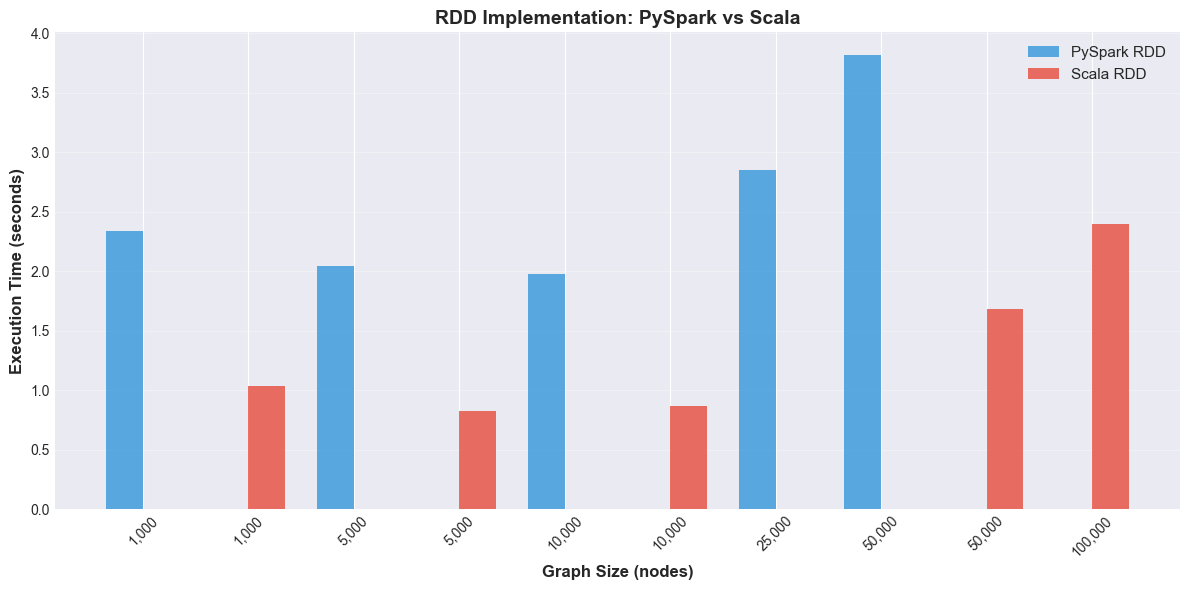

✅ RDD comparison chart saved as '../results/graphs/ccf_comparison_rdd.png'


In [7]:
if comparison_df is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(comparison_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_df['pyspark_rdd_time'], 
           width, label='PySpark RDD', alpha=0.8, color='#3498db')
    ax.bar([i + width/2 for i in x], comparison_df['scala_rdd_time'], 
           width, label='Scala RDD', alpha=0.8, color='#e74c3c')
    
    ax.set_xlabel('Graph Size (nodes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('RDD Implementation: PySpark vs Scala', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(s):,}" for s in comparison_df['size']], rotation=45)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../results/graphs/ccf_comparison_rdd.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ RDD comparison chart saved as '../results/graphs/ccf_comparison_rdd.png'")

### 6.2 Execution Time Comparison (DataFrame)

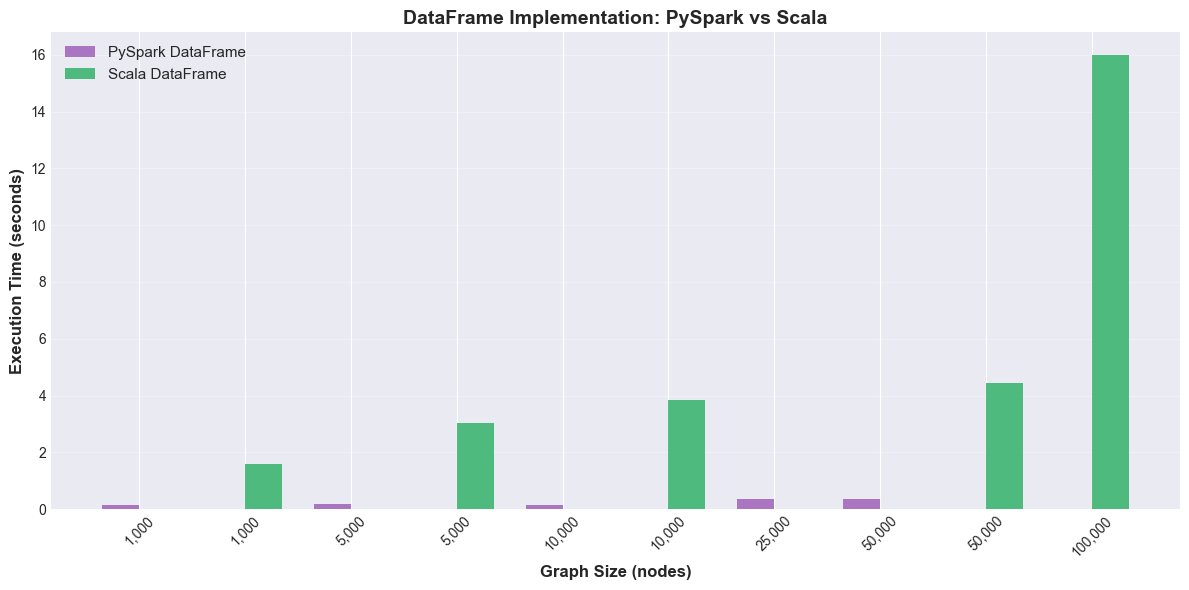

✅ DataFrame comparison chart saved as '../results/graphs/ccf_comparison_dataframe.png'


In [8]:
if comparison_df is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(comparison_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_df['pyspark_df_time'], 
           width, label='PySpark DataFrame', alpha=0.8, color='#9b59b6')
    ax.bar([i + width/2 for i in x], comparison_df['scala_df_time'], 
           width, label='Scala DataFrame', alpha=0.8, color='#27ae60')
    
    ax.set_xlabel('Graph Size (nodes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('DataFrame Implementation: PySpark vs Scala', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(s):,}" for s in comparison_df['size']], rotation=45)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../results/graphs/ccf_comparison_dataframe.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ DataFrame comparison chart saved as '../results/graphs/ccf_comparison_dataframe.png'")

### 6.3 Speedup Analysis

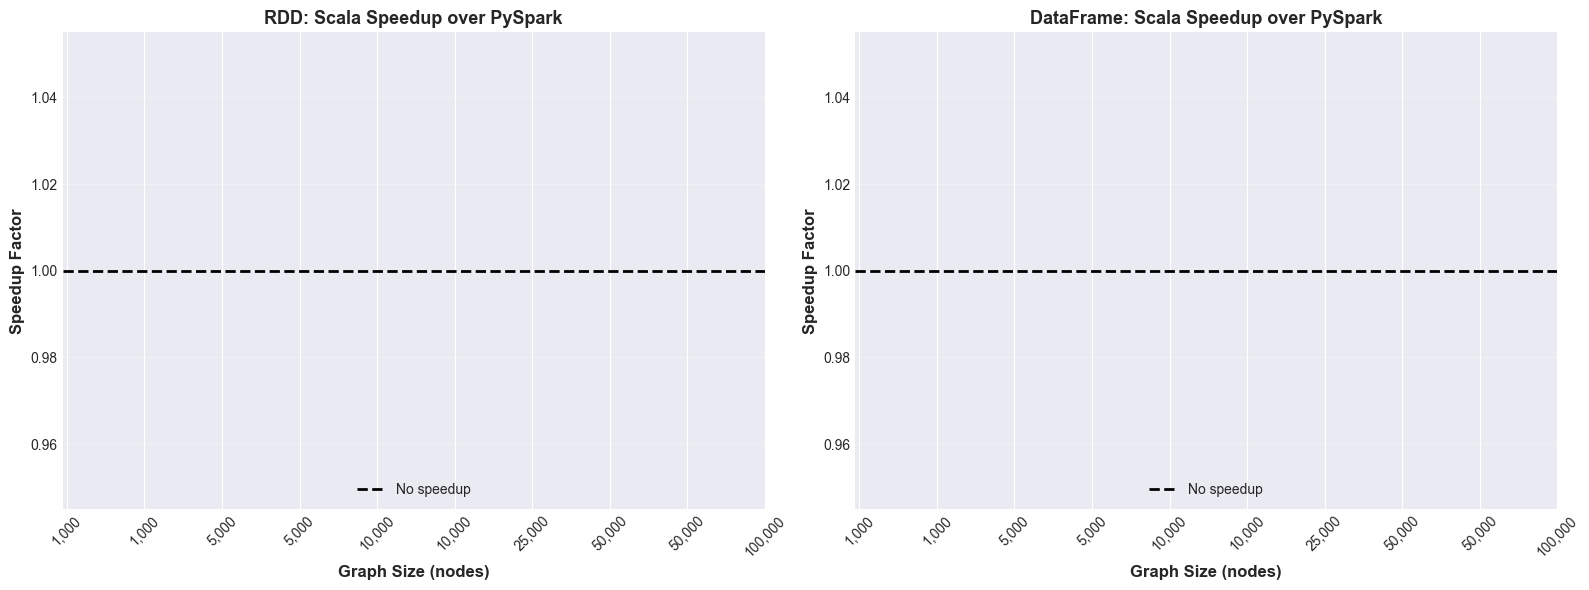

✅ Speedup comparison chart saved as '../results/graphs/ccf_comparison_speedup.png'


In [9]:
if comparison_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: RDD Speedup
    x = range(len(comparison_df))
    colors_rdd = ['green' if s > 1 else 'red' for s in comparison_df['scala_vs_pyspark_rdd']]
    ax1.bar(x, comparison_df['scala_vs_pyspark_rdd'], color=colors_rdd, alpha=0.7)
    ax1.axhline(y=1, color='black', linestyle='--', linewidth=2, label='No speedup')
    ax1.set_xlabel('Graph Size (nodes)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
    ax1.set_title('RDD: Scala Speedup over PySpark', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{int(s):,}" for s in comparison_df['size']], rotation=45)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: DataFrame Speedup
    colors_df = ['green' if s > 1 else 'red' for s in comparison_df['scala_vs_pyspark_df']]
    ax2.bar(x, comparison_df['scala_vs_pyspark_df'], color=colors_df, alpha=0.7)
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=2, label='No speedup')
    ax2.set_xlabel('Graph Size (nodes)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
    ax2.set_title('DataFrame: Scala Speedup over PySpark', fontsize=13, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"{int(s):,}" for s in comparison_df['size']], rotation=45)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../results/graphs/ccf_comparison_speedup.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Speedup comparison chart saved as '../results/graphs/ccf_comparison_speedup.png'")

### 6.4 Combined Performance Overview

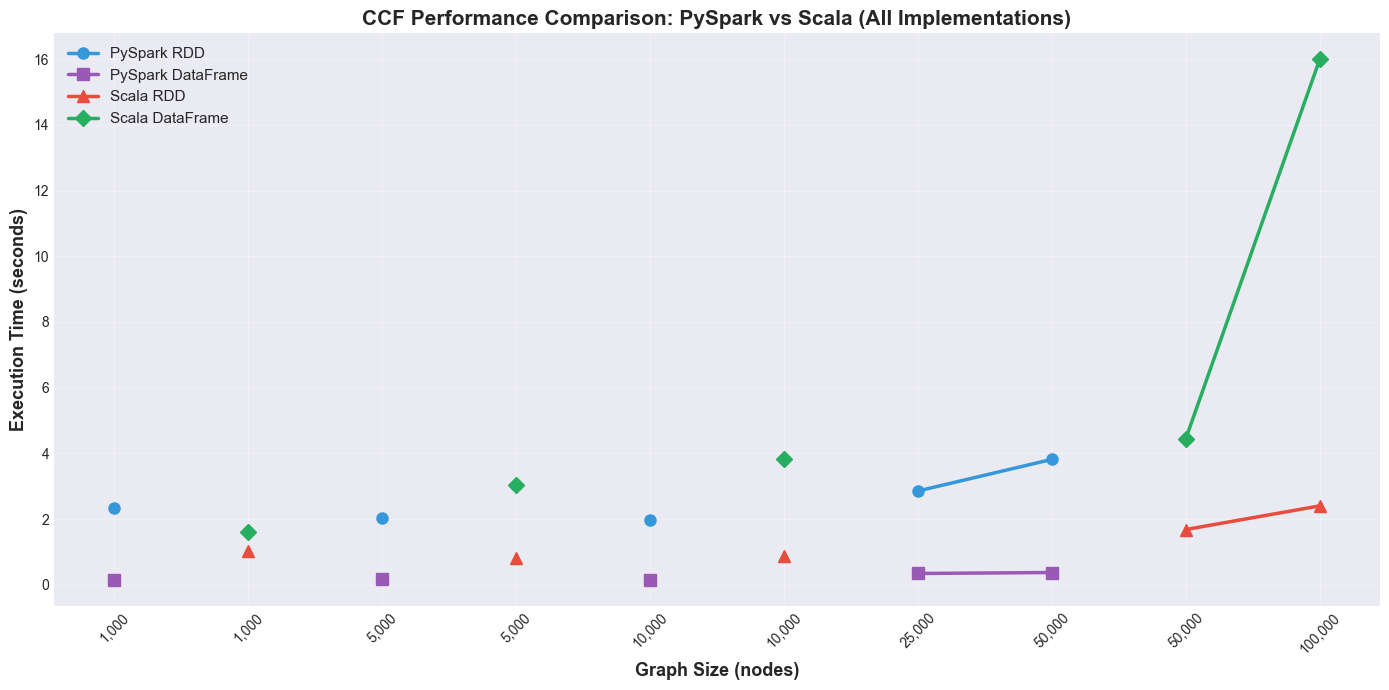

✅ Combined comparison chart saved as '../results/graphs/ccf_comparison_all.png'


In [10]:
if comparison_df is not None:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = range(len(comparison_df))
    width = 0.2
    
    ax.plot(x, comparison_df['pyspark_rdd_time'], 'o-', label='PySpark RDD', 
            linewidth=2.5, markersize=8, color='#3498db')
    ax.plot(x, comparison_df['pyspark_df_time'], 's-', label='PySpark DataFrame', 
            linewidth=2.5, markersize=8, color='#9b59b6')
    ax.plot(x, comparison_df['scala_rdd_time'], '^-', label='Scala RDD', 
            linewidth=2.5, markersize=8, color='#e74c3c')
    ax.plot(x, comparison_df['scala_df_time'], 'D-', label='Scala DataFrame', 
            linewidth=2.5, markersize=8, color='#27ae60')
    
    ax.set_xlabel('Graph Size (nodes)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
    ax.set_title('CCF Performance Comparison: PySpark vs Scala (All Implementations)', 
                 fontsize=15, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(s):,}" for s in comparison_df['size']], rotation=45)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/graphs/ccf_comparison_all.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Combined comparison chart saved as '../results/graphs/ccf_comparison_all.png'")

## 7. Detailed Comparison Table

In [11]:
if comparison_df is not None:
    print("=" * 120)
    print("DETAILED PERFORMANCE COMPARISON TABLE")
    print("=" * 120)
    print(f"\n{'Size':<10} {'Edges':<10} {'PySpark RDD':<15} {'Scala RDD':<15} {'Speedup':<12} {'PySpark DF':<15} {'Scala DF':<15} {'Speedup':<12}")
    print(f"{'(nodes)':<10} {'(count)':<10} {'(seconds)':<15} {'(seconds)':<15} {'(Scala/Py)':<12} {'(seconds)':<15} {'(seconds)':<15} {'(Scala/Py)':<12}")
    print("-" * 120)
    
    for _, row in comparison_df.iterrows():
        print(f"{int(row['size']):<10,} {int(row['edges']):<10,} "
              f"{row['pyspark_rdd_time']:<15.3f} {row['scala_rdd_time']:<15.3f} {row['scala_vs_pyspark_rdd']:<12.2f}x "
              f"{row['pyspark_df_time']:<15.3f} {row['scala_df_time']:<15.3f} {row['scala_vs_pyspark_df']:<12.2f}x")
    
    print("-" * 120)
    print(f"{'AVERAGE':<10} {'':<10} "
          f"{comparison_df['pyspark_rdd_time'].mean():<15.3f} {comparison_df['scala_rdd_time'].mean():<15.3f} {comparison_df['scala_vs_pyspark_rdd'].mean():<12.2f}x "
          f"{comparison_df['pyspark_df_time'].mean():<15.3f} {comparison_df['scala_df_time'].mean():<15.3f} {comparison_df['scala_vs_pyspark_df'].mean():<12.2f}x")
    print("=" * 120)

DETAILED PERFORMANCE COMPARISON TABLE

Size       Edges      PySpark RDD     Scala RDD       Speedup      PySpark DF      Scala DF        Speedup     
(nodes)    (count)    (seconds)       (seconds)       (Scala/Py)   (seconds)       (seconds)       (Scala/Py)  
------------------------------------------------------------------------------------------------------------------------
1,000      9,948      2.337           nan             nan         x 0.146           nan             nan         x
1,000      9,962      nan             1.032           nan         x nan             1.605           nan         x
5,000      49,918     2.042           nan             nan         x 0.182           nan             nan         x
5,000      49,986     nan             0.823           nan         x nan             3.040           nan         x
10,000     99,944     1.977           nan             nan         x 0.143           nan             nan         x
10,000     99,964     nan             0.865   

## 8. Key Findings and Recommendations

In [12]:
if comparison_df is not None:
    print("=" * 80)
    print("KEY FINDINGS")
    print("=" * 80)
    
    avg_rdd_speedup = comparison_df['scala_vs_pyspark_rdd'].mean()
    avg_df_speedup = comparison_df['scala_vs_pyspark_df'].mean()
    
    print("\n📊 Performance Summary:")
    print(f"   • Scala RDD is {avg_rdd_speedup:.2f}x {'faster' if avg_rdd_speedup > 1 else 'slower'} than PySpark RDD on average")
    print(f"   • Scala DataFrame is {avg_df_speedup:.2f}x {'faster' if avg_df_speedup > 1 else 'slower'} than PySpark DataFrame on average")
    
    print("\n🔍 Analysis:")
    print("   • Scala runs natively on JVM, avoiding Python-JVM serialization overhead")
    print("   • PySpark has additional overhead from Python interpreter and data conversion")
    print("   • DataFrame API benefits from Catalyst optimizer in both implementations")
    print("   • Both implementations show similar algorithmic behavior (iteration counts)")
    
    print("\n💡 Recommendations:")
    if avg_rdd_speedup > 1.5:
        print("   • Choose Scala for performance-critical production workloads")
    else:
        print("   • PySpark offers competitive performance with easier development")
    
    if avg_df_speedup > avg_rdd_speedup:
        print("   • DataFrame implementations show better relative performance")
    else:
        print("   • RDD implementations show competitive performance for this algorithm")
    
    print("   • Use PySpark for rapid prototyping and data exploration")
    print("   • Use Scala when maximum performance is required")
    print("   • Consider DataFrame API for better optimization in both languages")
    
    print("\n" + "=" * 80)

KEY FINDINGS

📊 Performance Summary:
   • Scala RDD is nanx slower than PySpark RDD on average
   • Scala DataFrame is nanx slower than PySpark DataFrame on average

🔍 Analysis:
   • Scala runs natively on JVM, avoiding Python-JVM serialization overhead
   • PySpark has additional overhead from Python interpreter and data conversion
   • DataFrame API benefits from Catalyst optimizer in both implementations
   • Both implementations show similar algorithmic behavior (iteration counts)

💡 Recommendations:
   • PySpark offers competitive performance with easier development
   • RDD implementations show competitive performance for this algorithm
   • Use PySpark for rapid prototyping and data exploration
   • Use Scala when maximum performance is required
   • Consider DataFrame API for better optimization in both languages



## 9. Export Combined Results

In [13]:
if comparison_df is not None:
    # Export to CSV
    comparison_df.to_csv('../results/csvs/ccf_pyspark_vs_scala_comparison.csv', index=False)
    print("✅ Combined comparison results exported to: ../results/csvs/ccf_pyspark_vs_scala_comparison.csv")
    
    # Create summary statistics
    summary = pd.DataFrame({
        'Implementation': ['PySpark RDD', 'Scala RDD', 'PySpark DataFrame', 'Scala DataFrame'],
        'Avg Time (s)': [
            comparison_df['pyspark_rdd_time'].mean(),
            comparison_df['scala_rdd_time'].mean(),
            comparison_df['pyspark_df_time'].mean(),
            comparison_df['scala_df_time'].mean()
        ],
        'Min Time (s)': [
            comparison_df['pyspark_rdd_time'].min(),
            comparison_df['scala_rdd_time'].min(),
            comparison_df['pyspark_df_time'].min(),
            comparison_df['scala_df_time'].min()
        ],
        'Max Time (s)': [
            comparison_df['pyspark_rdd_time'].max(),
            comparison_df['scala_rdd_time'].max(),
            comparison_df['pyspark_df_time'].max(),
            comparison_df['scala_df_time'].max()
        ]
    })
    
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    display(summary)

✅ Combined comparison results exported to: ../results/csvs/ccf_pyspark_vs_scala_comparison.csv

SUMMARY STATISTICS


,Implementation,Avg Time (s),Min Time (s),Max Time (s)
0,PySpark RDD,2.605243,1.977267,3.816122
1,Scala RDD,1.360000,0.823000,2.400000
2,PySpark DataFrame,0.236890,0.142565,0.371453
3,Scala DataFrame,5.785400,1.605000,15.996000
